<a href="https://colab.research.google.com/github/Darkblazer21/vehicle_classifier/blob/dev/vehicle_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building A Vehicle Classifier Using Fastai

### By KingBrems 👑

Let's start by installing Fastbook In Our Colab Notebook

In [1]:
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.1 MB/s eta 0:00:00


# Importing the fastai vision library

This allows to get all relevant functions and classes for our image classification tasks

In [1]:
from fastai.vision.all import *

# Gathering the data

Let's now gather some data. Our different image classes are:
- car
- motorcycle
- truck
- bus
- bicycle
- train
- scooter

To download images we'll use `search_images_ddg` which a function provided by the fastai library, which will allow us to gather images using the `duck duck go` search api

In [2]:
!pip install -q jmd_imagescraper

Let's now import all the relevant libraries in order to successfully download images using the `jmd_imagescraper`

In [3]:
from pathlib import Path
from jmd_imagescraper.core import *

In [4]:
root = Path().cwd()/"images" # We instantiate the Path object for our images

The following code overwrite root folder if it already exists

In [7]:
if root.exists():
    import shutil
    shutil.rmtree(root)

Lets now instanciate a list that will contain our search terms

In [8]:
search_terms = ['car', 'motorcycle', 'truck', 'bus', 'bicycle','train', 'scooter']
# I set max number of 100 images as results
max_results=100

In [9]:
for term in search_terms:
  duckduckgo_search(root, '_'.join(term.split()), term, max_results=max_results)

Duckduckgo search: car


Duckduckgo search: motorcycle


Duckduckgo search: truck


Duckduckgo search: bus


Duckduckgo search: bicycle


Duckduckgo search: train


Duckduckgo search: scooter


In [9]:
doc(get_image_files)

get_image_files(path, recurse=True, folders=None)
Get image files in `path` recursively, only in `folders`, if specified.

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


With the code below we check how many images have been downloaded

In [10]:
files = get_image_files(root)
len(files)

700

Then we check if there is any failure with the download by using the `verify_images` function and the `len` function

In [11]:
failed = verify_images(files)
failed

(#0) []

In [12]:
len(failed)

0

### This is the equivalent of the above code using the os library

In [ ]:
# import os

# count = 0
# for root_dir, cur_dir, files in os.walk(root):
    # count += len(files)
# print('file count:', count)

file count: 700


##### It seems everything is working fine so we can now instanciate the dataset using the `DataBlock` api

<br>

# Let's now use the DataBlock API from the fastai library

In [18]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_items = get_image_files,
                splitter = RandomSplitter(valid_pct=0.2, seed=42),
                get_y = parent_label,
                item_tfms = Resize(224)
                )

### Some explanation of what happened above

By itself, a DataBlock is just a blue print on how to assemble our data. It does not do anything until we pass it a source. we can choose to then convert that source into a Datasets or a DataLoaders by using the `DataBlock.datasets` or `DataBlock.dataloaders` method.
With the `Resize`, we are now able to `batch` items together and can finally call `dataloaders` to convert our `DataBlock` to a `DataLoaders` object:

In [19]:
dls = dblock.dataloaders(root)

We can now use the `show_batch` method to show a batch of items

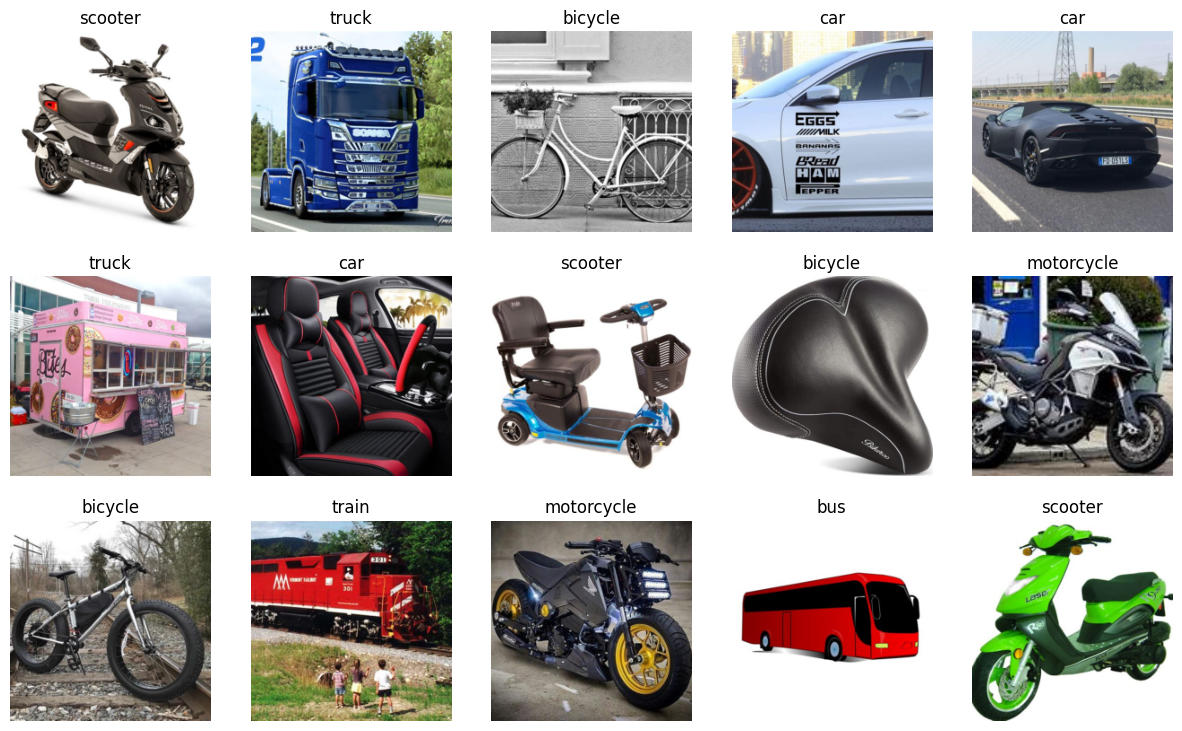

In [31]:
dls.show_batch(max_n=15)